# Kernel-Based Conditional Density Estimation Notebook

 In this notebook we generate Brownian motion trajectories, "train" a conditional density estimator using a kernel‐based method, 
 and then evaluate the estimator by drawing samples at a specific stage.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt

import sys
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


measure_sampling_path = os.path.abspath('/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Measure_sampling')
CD_path = os.path.abspath('/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Conditional_density')

if measure_sampling_path not in sys.path:
    sys.path.append(measure_sampling_path)

if CD_path not in sys.path:
    sys.path.append(CD_path)

from CD_nonparam import *

from Gen_Path_and_AdaptedTrees import *


from scipy.stats import norm

In [2]:
# Generate Brownian motion paths
n_data =  30
time_steps = 4  # For example, t=0, t=1, t=2, t=3
paths = generate_brownian_motion(num_paths=n_data, time_steps=time_steps, scale=1)

Squared Wasserstein distance for x0 = 0: 0.0511
Squared Wasserstein distance for x0 = 1: 0.0536
Squared Wasserstein distance for x0 = 2: 0.0926
Squared Wasserstein distance for x0 = 0.75: 0.0471


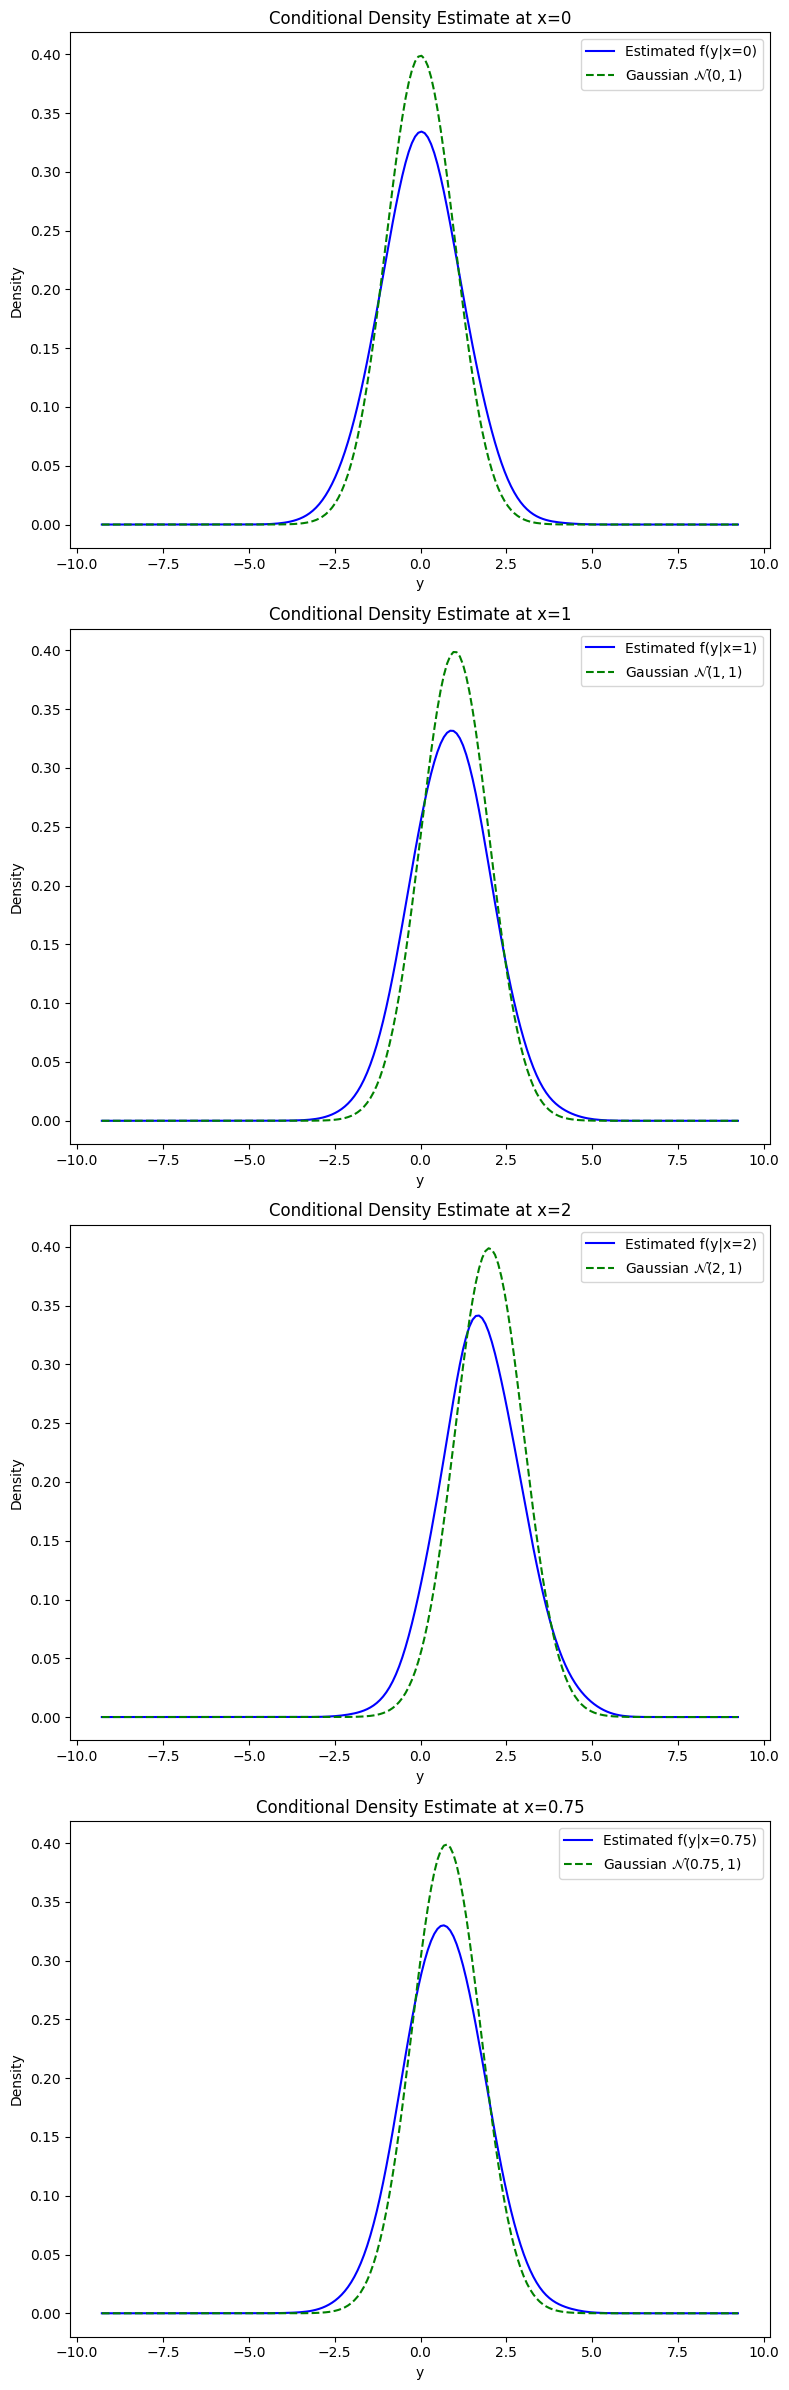

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assuming estimate_conditional_density_one_step is defined elsewhere

def generate_brownian_motion(num_paths, time_steps, scale=1.0):
    dt = 1.0
    # Each path is a cumulative sum of Gaussian increments.
    paths = np.cumsum(np.random.normal(0, scale * np.sqrt(dt), size=(num_paths, time_steps)), axis=1)
    return paths

# Generate data
num_paths = 6000
time_steps = 3
paths = generate_brownian_motion(num_paths, time_steps, scale=1.0)

# For conditional density estimation, let’s say we want to condition on a value of x at time step 2
# and estimate the density for y at time step 3.
X = paths[:, 1].reshape(-1, 1)
Y = paths[:, 2].reshape(-1, 1)
data = np.concatenate([X, Y], axis=1)

# Define a grid of y values covering the range of Y (plus a little margin)
y_min = np.min(Y) - 3
y_max = np.max(Y) + 3
y_grid = np.linspace(y_min, y_max, 200)

# Set bandwidth parameters (you may need to tune these)
bandwidth_joint = 0.5
bandwidth_marginal = 0.5

# Define multiple x_0 values
x_values = [0, 1, 2, 0.75]

# Create subplots
fig, axs = plt.subplots(len(x_values), 1, figsize=(8, 6 * len(x_values)))
if not isinstance(axs, np.ndarray):
    axs = [axs]

# Create a grid for u values to compute quantile functions
u_grid = np.linspace(0, 1, 200)

# Loop over each x_0 value
for i, x0 in enumerate(x_values):

    # Estimate the conditional density f(y|x0)
    f_cond = estimate_conditional_density_one_step(data, x0, bandwidth_joint, bandwidth_marginal, y_grid)

    # Compute Gaussian distribution centered at x0 with variance = 1
    gaussian = norm.pdf(y_grid, loc=x0, scale=1)

    # Plot the estimated conditional density
    axs[i].plot(y_grid, f_cond, label=f"Estimated f(y|x={x0})", color='b')
    # Plot Gaussian distribution
    axs[i].plot(y_grid, gaussian, 'g--', label=f"Gaussian $\\mathcal{{N}}({x0},1)$")
    axs[i].set_title(f"Conditional Density Estimate at x={x0}")
    axs[i].set_xlabel("y")
    axs[i].set_ylabel("Density")
    axs[i].legend()

    # Compute the cumulative distribution functions (CDFs) from the densities
    dx = y_grid[1] - y_grid[0]
    cdf_est = np.cumsum(f_cond) * dx
    cdf_true = np.cumsum(gaussian) * dx

    # Make sure the CDFs start at 0 and end at 1 for proper inversion.
    cdf_est[0] = 0.0
    cdf_est[-1] = 1.0
    cdf_true[0] = 0.0
    cdf_true[-1] = 1.0

    # Compute the quantile functions via interpolation
    Q_est = np.interp(u_grid, cdf_est, y_grid)
    Q_true = np.interp(u_grid, cdf_true, y_grid)

    # Compute the squared 2-Wasserstein distance via numerical integration
    W2_squared = np.trapz((Q_est - Q_true)**2, u_grid)
    
    # Print the squared Wasserstein distance for this x0 value
    print(f"Squared Wasserstein distance for x0 = {x0}: {W2_squared:.4f}")

plt.tight_layout()
plt.show()



Squared Wasserstein distance for x0 = 0: 0.0120
Squared Wasserstein distance for x0 = 1: 0.0141
Squared Wasserstein distance for x0 = 2: 0.0204
Squared Wasserstein distance for x0 = 0.75: 0.0133


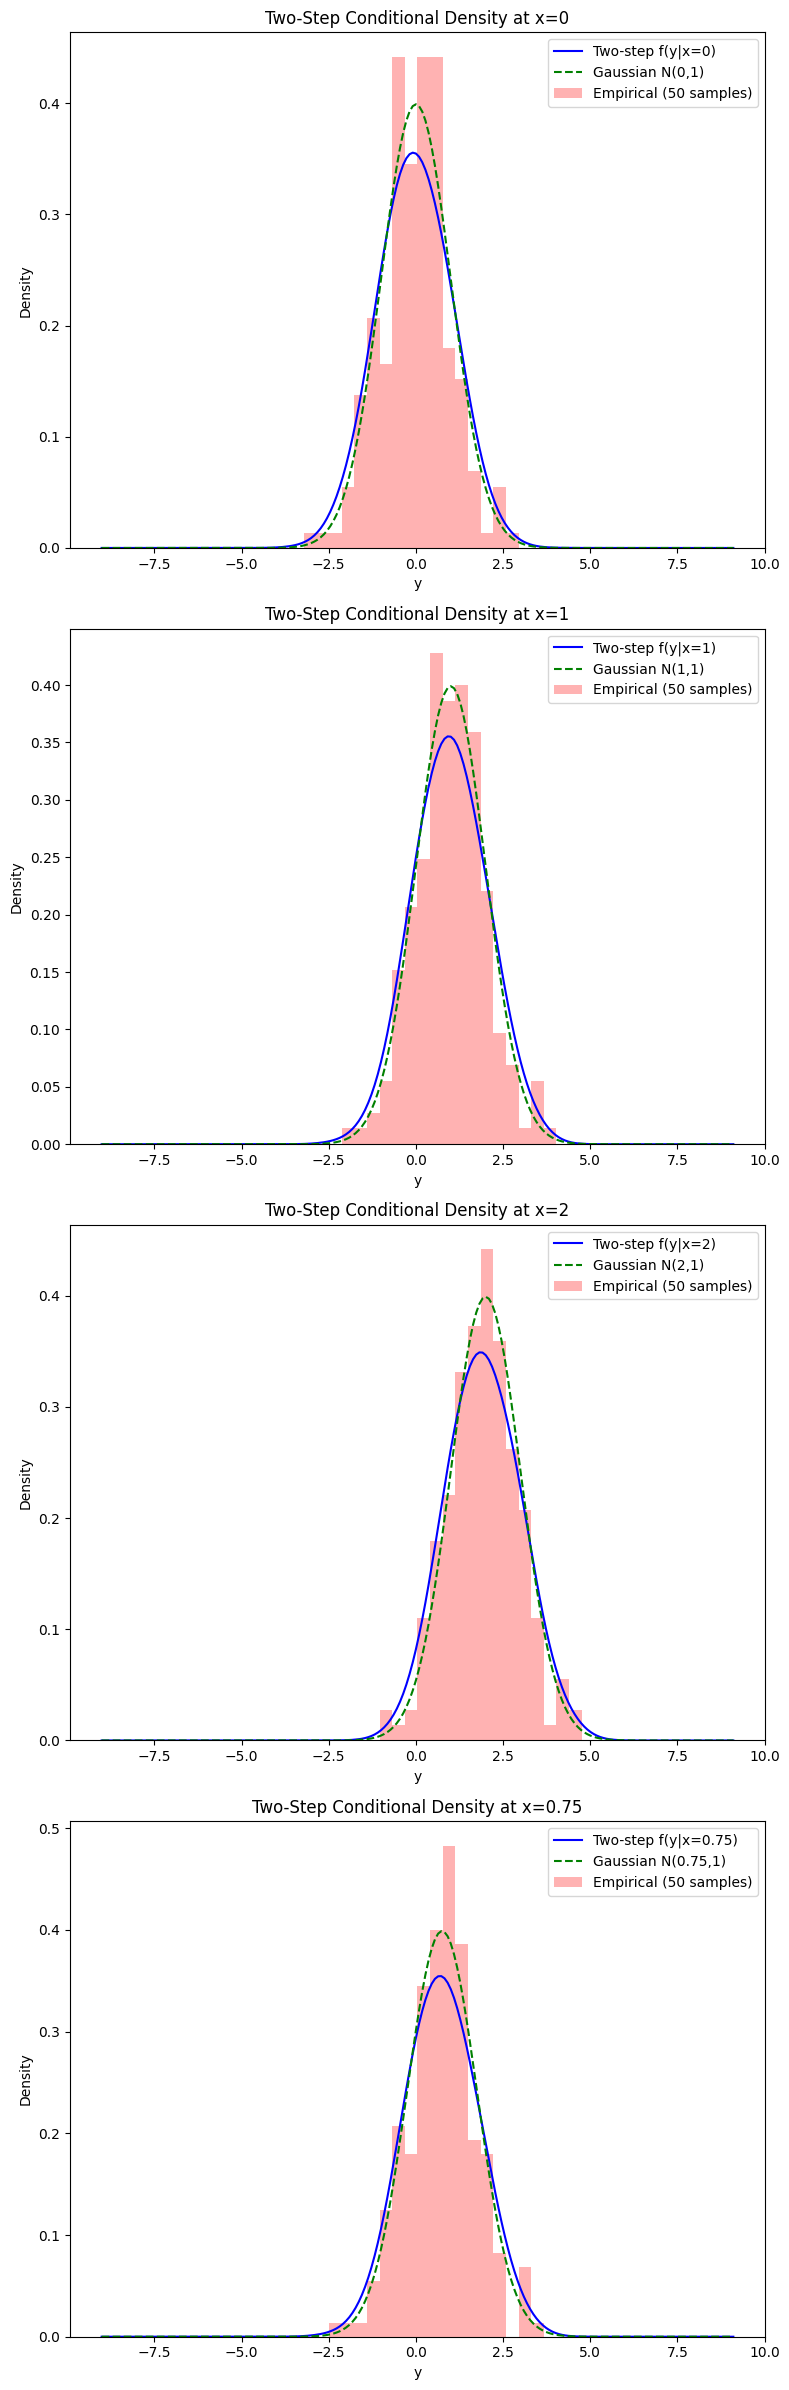

In [7]:
# Generate synthetic Brownian motion data
num_paths = 6000
time_steps = 3
paths = generate_brownian_motion(num_paths, time_steps, scale=1.0)

# We'll take X to be the value at time step 2, Y at time step 3
X = paths[:, 1].reshape(-1, 1)
Y = paths[:, 2].reshape(-1, 1)
data = np.concatenate([X, Y], axis=1)

# Define a grid of y values
y_min = np.min(Y) - 3
y_max = np.max(Y) + 3
y_grid = np.linspace(y_min, y_max, 200)
dy = y_grid[1] - y_grid[0]  # grid spacing

# Set bandwidth parameters for the two-step estimator
bandwidth_x = 0.5  # for local regression
bandwidth_e = 0.5  # for residual density

# Define multiple x_0 values
x_values = [0, 1, 2, 0.75]

# Create subplots
fig, axs = plt.subplots(len(x_values), 1, figsize=(8, 6 * len(x_values)))
if not isinstance(axs, np.ndarray):
    axs = [axs]  # in case there's only one subplot

for i, x0 in enumerate(x_values):
    
    # --- Call the two-step estimator ---
    f_cond_two_step = estimate_conditional_density_two_step(
        data, x0, bandwidth_x, bandwidth_e, y_grid
    )
    
    # Convert continuous density to discrete probabilities over the grid
    # We multiply by the grid spacing to approximate the integral
    pmf = f_cond_two_step * dy
    pmf /= pmf.sum()  # normalize so it sums to 1
    
    # Sample 50 points from that discrete distribution
    np.random.seed(123)  # for reproducibility; remove or change as needed
    samples = np.random.choice(y_grid, size=200, p=pmf)
    
    # Plot the two-step estimated conditional density
    axs[i].plot(y_grid, f_cond_two_step, label=f"Two-step f(y|x={x0})", color='b')
    
    # Plot a Gaussian with mean = x0 and variance = 1, for comparison
    gaussian = norm.pdf(y_grid, loc=x0, scale=1)
    axs[i].plot(y_grid, gaussian, 'g--', label=f"Gaussian N({x0},1)")
    
    # Overlay an empirical histogram of the 50 samples
    # Use 'density=True' to scale histogram so it can be compared to the PDF
    axs[i].hist(samples, bins=50, range=(y_min, y_max),
                alpha=0.3, color='r', density=True, 
                label=f"Empirical (50 samples)")
    
    # Labels and title
    axs[i].set_title(f"Two-Step Conditional Density at x={x0}")
    axs[i].set_xlabel("y")
    axs[i].set_ylabel("Density")
    axs[i].legend()

        # Compute the cumulative distribution functions (CDFs) from the densities
    dx = y_grid[1] - y_grid[0]
    cdf_est = np.cumsum(f_cond_two_step) * dx
    cdf_true = np.cumsum(gaussian) * dx

    # Make sure the CDFs start at 0 and end at 1 for proper inversion.
    cdf_est[0] = 0.0
    cdf_est[-1] = 1.0
    cdf_true[0] = 0.0
    cdf_true[-1] = 1.0

    # Compute the quantile functions via interpolation
    Q_est = np.interp(u_grid, cdf_est, y_grid)
    Q_true = np.interp(u_grid, cdf_true, y_grid)

    # Compute the squared 2-Wasserstein distance via numerical integration
    W2_squared = np.trapz((Q_est - Q_true)**2, u_grid)
    
    # Print the squared Wasserstein distance for this x0 value
    print(f"Squared Wasserstein distance for x0 = {x0}: {W2_squared:.4f}")

plt.tight_layout()
plt.show()

## Now we will analyse discretization scheme that minimize the Wasserstein distance

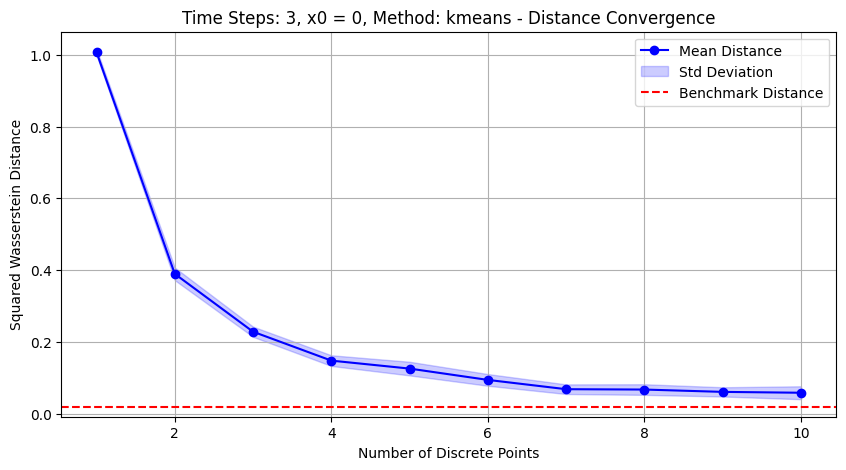

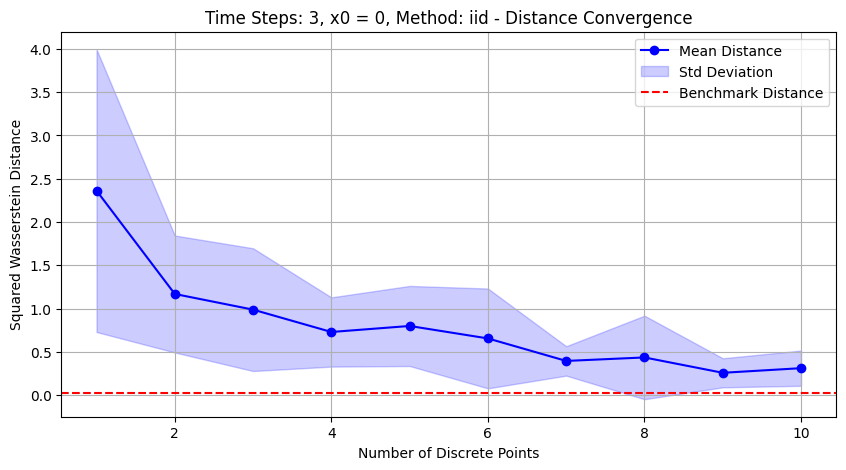

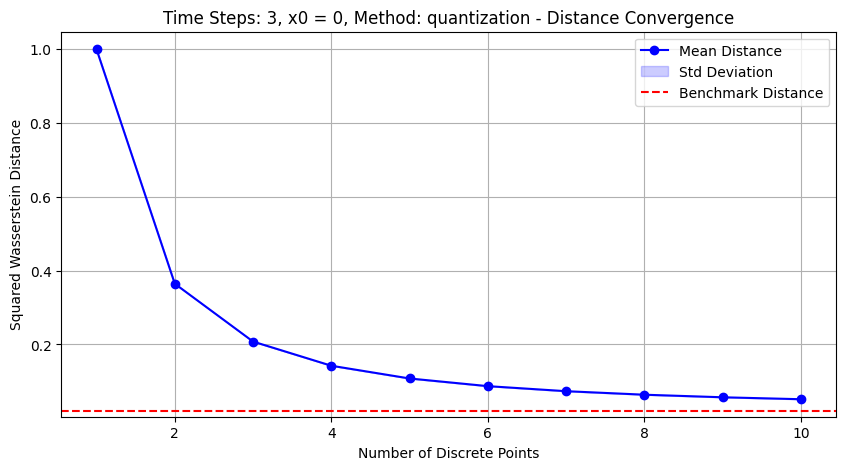

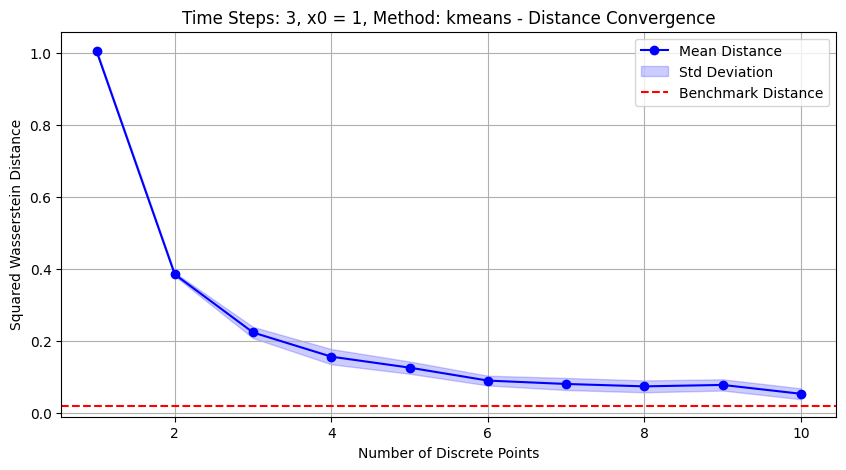

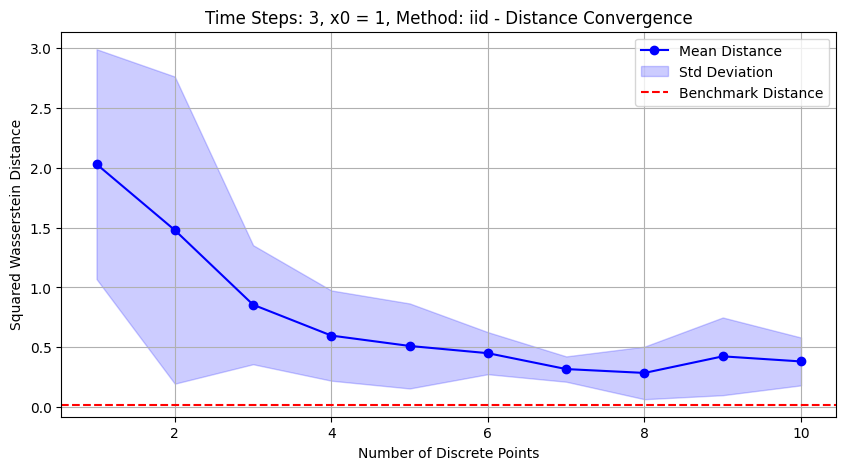

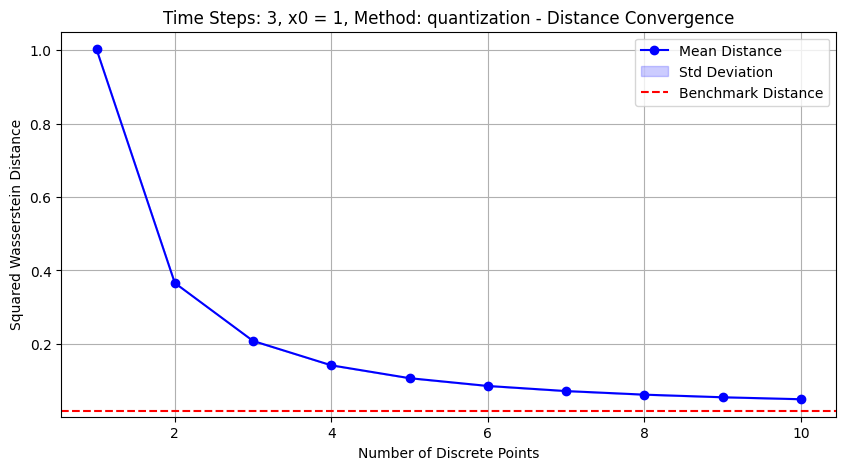

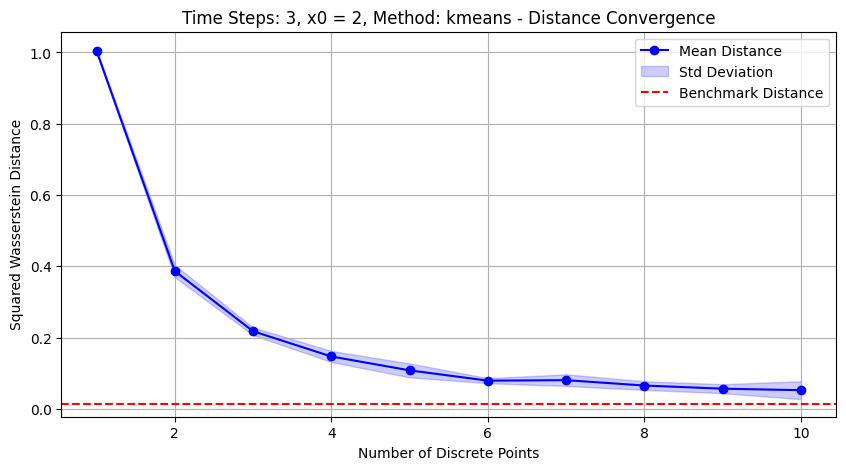

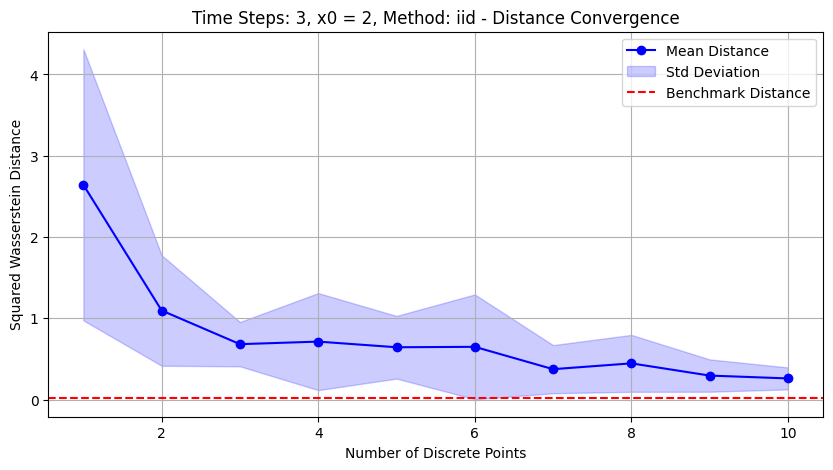

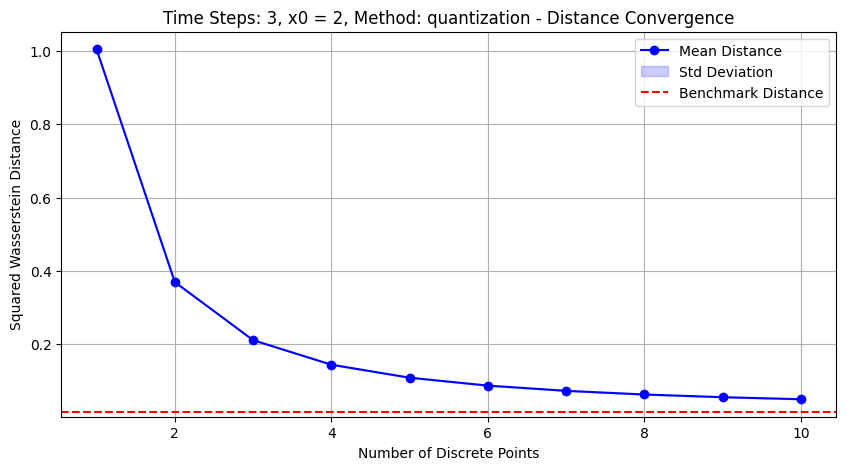

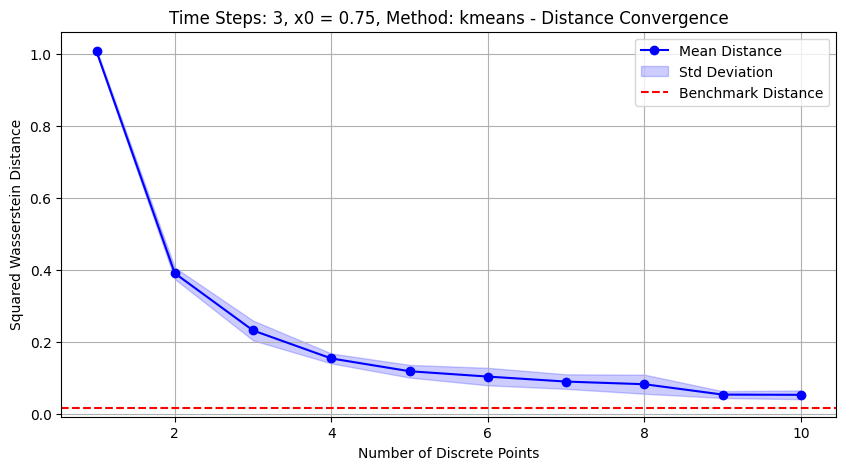

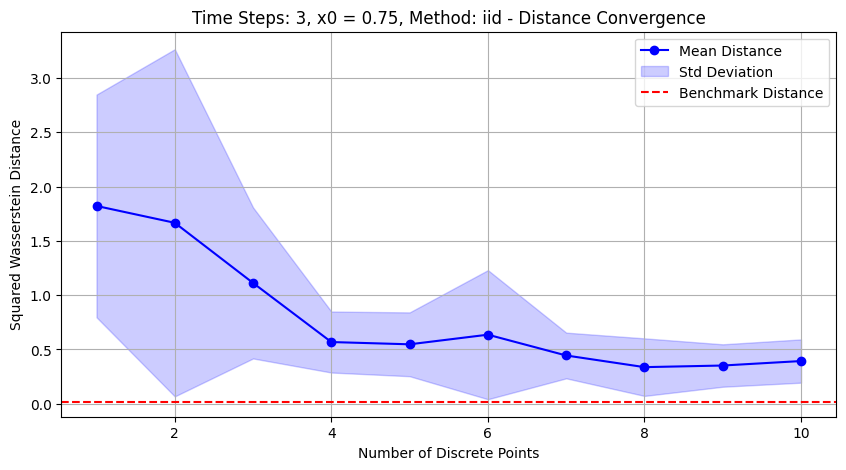

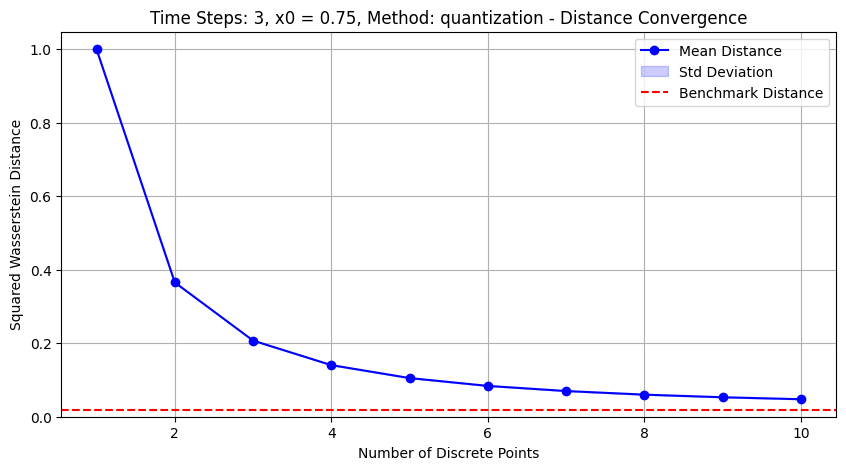

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import ot  # POT library for optimal transport
from sklearn.cluster import KMeans

# --- Helper Functions ---

def generate_brownian_motion(num_paths, time_steps, scale=1.0):
    dt = 1.0
    # Each path is a cumulative sum of Gaussian increments.
    paths = np.cumsum(np.random.normal(0, scale * np.sqrt(dt), size=(num_paths, time_steps)), axis=1)
    return paths

# (Assume this function is defined based on your previous implementation.)
# It should estimate the conditional density f(y|x0) on the grid y_grid.
def estimate_conditional_density_one_step(data, x0, bandwidth_joint, bandwidth_marginal, y_grid):
    # For illustration, here we use a simple kernel density estimator.
    # In practice you should use your own implementation.
    from sklearn.neighbors import KernelDensity
    # We select only the points with x values near x0 (a rough approximation)
    idx = np.abs(data[:, 0] - x0) < bandwidth_joint
    y_vals = data[idx, 1]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth_marginal).fit(y_vals.reshape(-1, 1))
    log_dens = kde.score_samples(y_grid.reshape(-1, 1))
    dens = np.exp(log_dens)
    return dens

def compute_w2_squared(discrete_support, discrete_weights, true_support, true_weights):
    """
    Compute squared 2-Wasserstein distance between two discrete measures.
    discrete_support: 1D numpy array of support points (length m)
    discrete_weights: 1D numpy array of weights (length m, summing to 1)
    true_support: 1D numpy array of support points for the true measure (length n)
    true_weights: 1D numpy array of weights for the true measure (length n, summing to 1)
    """
    # Compute the squared Euclidean cost matrix between the supports.
    M = (discrete_support[:, None] - true_support[None, :])**2
    # ot.emd2 returns the squared Wasserstein distance
    return ot.emd2(discrete_weights, true_weights, M)

# --- Setup ---

# Generate Brownian motion data
num_paths = 6000
time_steps = 3
paths = generate_brownian_motion(num_paths, time_steps, scale=1.0)

# For conditional density estimation:
# Let x = value at time step 2 and y = value at time step 3.
X = paths[:, 1].reshape(-1, 1)
Y = paths[:, 2].reshape(-1, 1)
data = np.concatenate([X, Y], axis=1)

# Define a grid of y values (covering the range of Y with some margin)
y_min = np.min(Y) - 3
y_max = np.max(Y) + 3
y_grid = np.linspace(y_min, y_max, 800)
dx = y_grid[1] - y_grid[0]

# Bandwidth parameters for the density estimation (may need tuning)
bandwidth_joint = 0.5
bandwidth_marginal = 0.5

# x0 values to condition on:
x_values = [0, 1, 2, 0.75]

# Number of runs for each discrete size to compute statistics
num_runs = 10
# For k-means, use a larger sample from the estimated density
sample_size_for_kmeans = 200

# --- Loop over each x0 ---
for x0 in x_values:
    # Estimate the conditional density f(y|x0) on the grid y_grid
    f_cond = estimate_conditional_density_one_step(data, x0, bandwidth_joint, bandwidth_marginal, y_grid)
    
    # Normalize the estimated density (discrete measure on y_grid)
    est_weights = f_cond * dx
    est_weights = est_weights / np.sum(est_weights)
    
    # Construct the "true" measure as the Gaussian N(x0,1) discretized on y_grid
    true_pdf = norm.pdf(y_grid, loc=x0, scale=1)
    true_weights = true_pdf * dx
    true_weights = true_weights / np.sum(true_weights)
    
    # Compute benchmark squared Wasserstein distance between the full estimated density and the true measure.
    M_cont = (y_grid[:, None] - y_grid[None, :])**2
    benchmark_distance = ot.emd2(est_weights, true_weights, M_cont)
    
    # Dictionary to store results for each method and for discrete sizes n=1,...,10.
    methods = ['kmeans', 'iid', 'quantization']
    results = {method: {n: [] for n in range(1, 11)} for method in methods}
    
    # Pre-calculate sampling probabilities from the estimated density.
    sampling_prob = f_cond / np.sum(f_cond)
    
    # Run experiments: for each run, for each discrete size n.
    for run in range(num_runs):
        for n in range(1, 11):
            # ----- Method 1: K-means discretization -----
            # Sample 200 points from y_grid according to the estimated density.
            sample_points = np.random.choice(y_grid, size=sample_size_for_kmeans, p=sampling_prob)
            sample_points = sample_points.reshape(-1, 1)  # KMeans expects 2D array
            kmeans = KMeans(n_clusters=n, n_init=10)
            kmeans.fit(sample_points)
            centers = kmeans.cluster_centers_.flatten()
            # Weight for each cluster: proportion of points assigned to it.
            _, counts = np.unique(kmeans.labels_, return_counts=True)
            kmeans_weights = counts / sample_size_for_kmeans
            # Compute squared Wasserstein distance between the k-means discrete measure and the true measure.
            dist_km = compute_w2_squared(centers, kmeans_weights, y_grid, true_weights)
            results['kmeans'][n].append(dist_km)
            
            # ----- Method 2: i.i.d. sampling discretization -----
            # Sample n points directly from the estimated density.
            iid_samples = np.random.choice(y_grid, size=n, p=sampling_prob)
            iid_weights = np.ones(n) / n
            dist_iid = compute_w2_squared(iid_samples, iid_weights, y_grid, true_weights)
            results['iid'][n].append(dist_iid)
            
            # ----- Method 3: Classical quantization discretization -----
            # Compute the CDF from the estimated density.
            cdf_est = np.cumsum(f_cond * dx)
            # Ensure proper endpoints.
            cdf_est[0] = 0.0
            cdf_est[-1] = 1.0
            # Use equally spaced quantiles (midpoints of intervals) to define discrete points.
            quantiles = (np.arange(n) + 0.5) / n
            quantization_points = np.interp(quantiles, cdf_est, y_grid)
            quantization_weights = np.ones(n) / n
            dist_quant = compute_w2_squared(quantization_points, quantization_weights, y_grid, true_weights)
            results['quantization'][n].append(dist_quant)
    
    # --- Plotting for each discretization method for the current x0 ---
    for method in methods:
        sample_sizes = []
        distances_mean = []
        distances_std = []
        for n in range(1, 11):
            sample_sizes.append(n)
            dists = results[method][n]
            distances_mean.append(np.mean(dists))
            distances_std.append(np.std(dists))
        
        plt.figure(figsize=(10, 5))
        plt.plot(sample_sizes, distances_mean, marker="o", color="blue", label="Mean Distance")
        plt.fill_between(
            sample_sizes, 
            np.array(distances_mean) - np.array(distances_std), 
            np.array(distances_mean) + np.array(distances_std), 
            color="blue", alpha=0.2, label="Std Deviation"
        )
        plt.axhline(y=benchmark_distance, color="red", linestyle="--", label="Benchmark Distance")
        plt.xlabel("Number of Discrete Points")
        plt.ylabel("Squared Wasserstein Distance")
        plt.title(f"Time Steps: {time_steps}, x0 = {x0}, Method: {method} - Distance Convergence")
        plt.legend()
        plt.grid()
        plt.show()
